In [2]:
import os 
import re
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
nonbal_qso_samp_path = '../data/nonbal_qso_samp.csv'
nonbal_qso_samp_df = pd.read_csv(nonbal_qso_samp_path, index_col=0)

In [6]:
import numpy as np

import pandas as pd
from matplotlib import pyplot as plt

import astroquery
from astroquery.sdss import SDSS
import astropy
from astropy.table import Table
from astropy.io import fits
from astropy import units as u

from specutils import Spectrum1D


import sys
from urllib.error import HTTPError

from src.astroML.dimensionality.iterative_pca import iterative_pca
from src.astroML.datasets.sdss_spectrum import fetch_sdss_spectrum
from astroML.datasets import sdss_corrected_spectra 

In [ ]:
from specutils import SpectrumCollection
from specutils.manipulation import FluxConservingResampler
fluxcon = FluxConservingResampler()

spec_l = []

for idx, row in nonbal_qso_samp_df.iloc[0:50].iterrows():
    spec = fetch_sdss_spectrum(row.PLATE, row.MJD, row.FIBERID, row.Z, row.AUTOCLASS_PQN)
    spec.shift_spectrum_to(redshift=0)
    spec = spec[1260*u.AA:2400*u.AA]
    print(f'Processing spectrum {idx}')
    if idx == 0:
        spectral_axis = spec.spectral_axis
        bins = len(spec.spectral_axis)
    else:
        if not np.array_equal(spec.spectral_axis, spectral_axis):
            print('Resampling axis')
            spec = fluxcon(spec, spectral_axis)
    # Dropping masking stuff for now... Need to revisit
    spec.mask = np.full((len(spec.spectral_axis)), False)
    spec_l.append(spec)



In [366]:
X_full

NameError: name 'X_full' is not defined

In [33]:
spec_coll = SpectrumCollection.from_spectra(spec_l)

In [34]:
X = np.array(spec_coll.flux)

In [35]:
wavelengths = np.array(spec_coll.spectral_axis)[0]

In [36]:
X = X[~np.isnan(X).any(axis=1)]

In [37]:
from sklearn.decomposition import PCA

X_train = X.T

pca = PCA(n_components=5, random_state=1234)
# pca_mle = PCA(n_components='mle', random_state=1234)

pca.fit(X_train)

PCA(n_components=5, random_state=1234)

In [38]:
X_reduced = np.dot(X_train - pca.mean_, pca.components_.T)
X_original = np.dot(X_reduced, pca.components_) + pca.mean_
X_diff = X_train - X_original

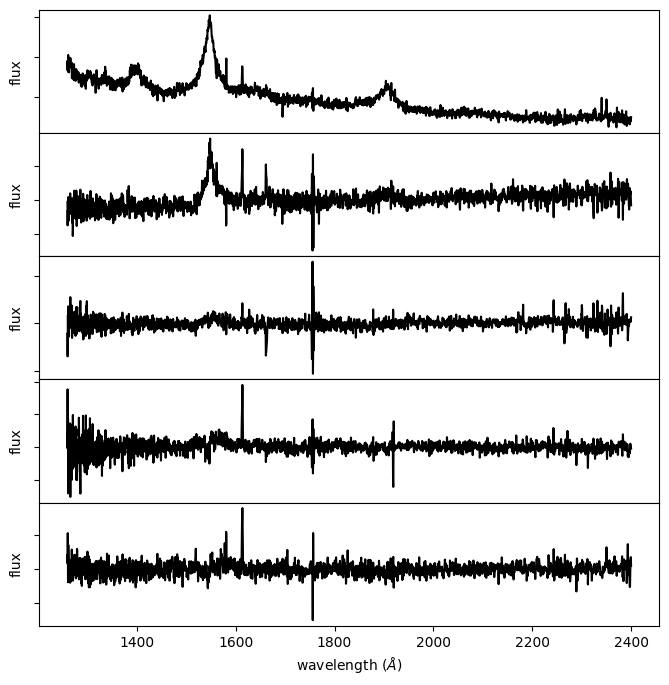

In [39]:
# Plot several spectra
fig = plt.figure(figsize=(8, 8))

fig.subplots_adjust(hspace=0)

for i in range(5):
    ax = fig.add_subplot(511 + i)
    ax.plot(wavelengths, X_reduced.T[i], '-k')

    if i < 4:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_xlabel(r'wavelength $(\AA)$')

    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_ylabel('flux')

plt.show()

In [40]:
X_train.shape

(2798, 18)

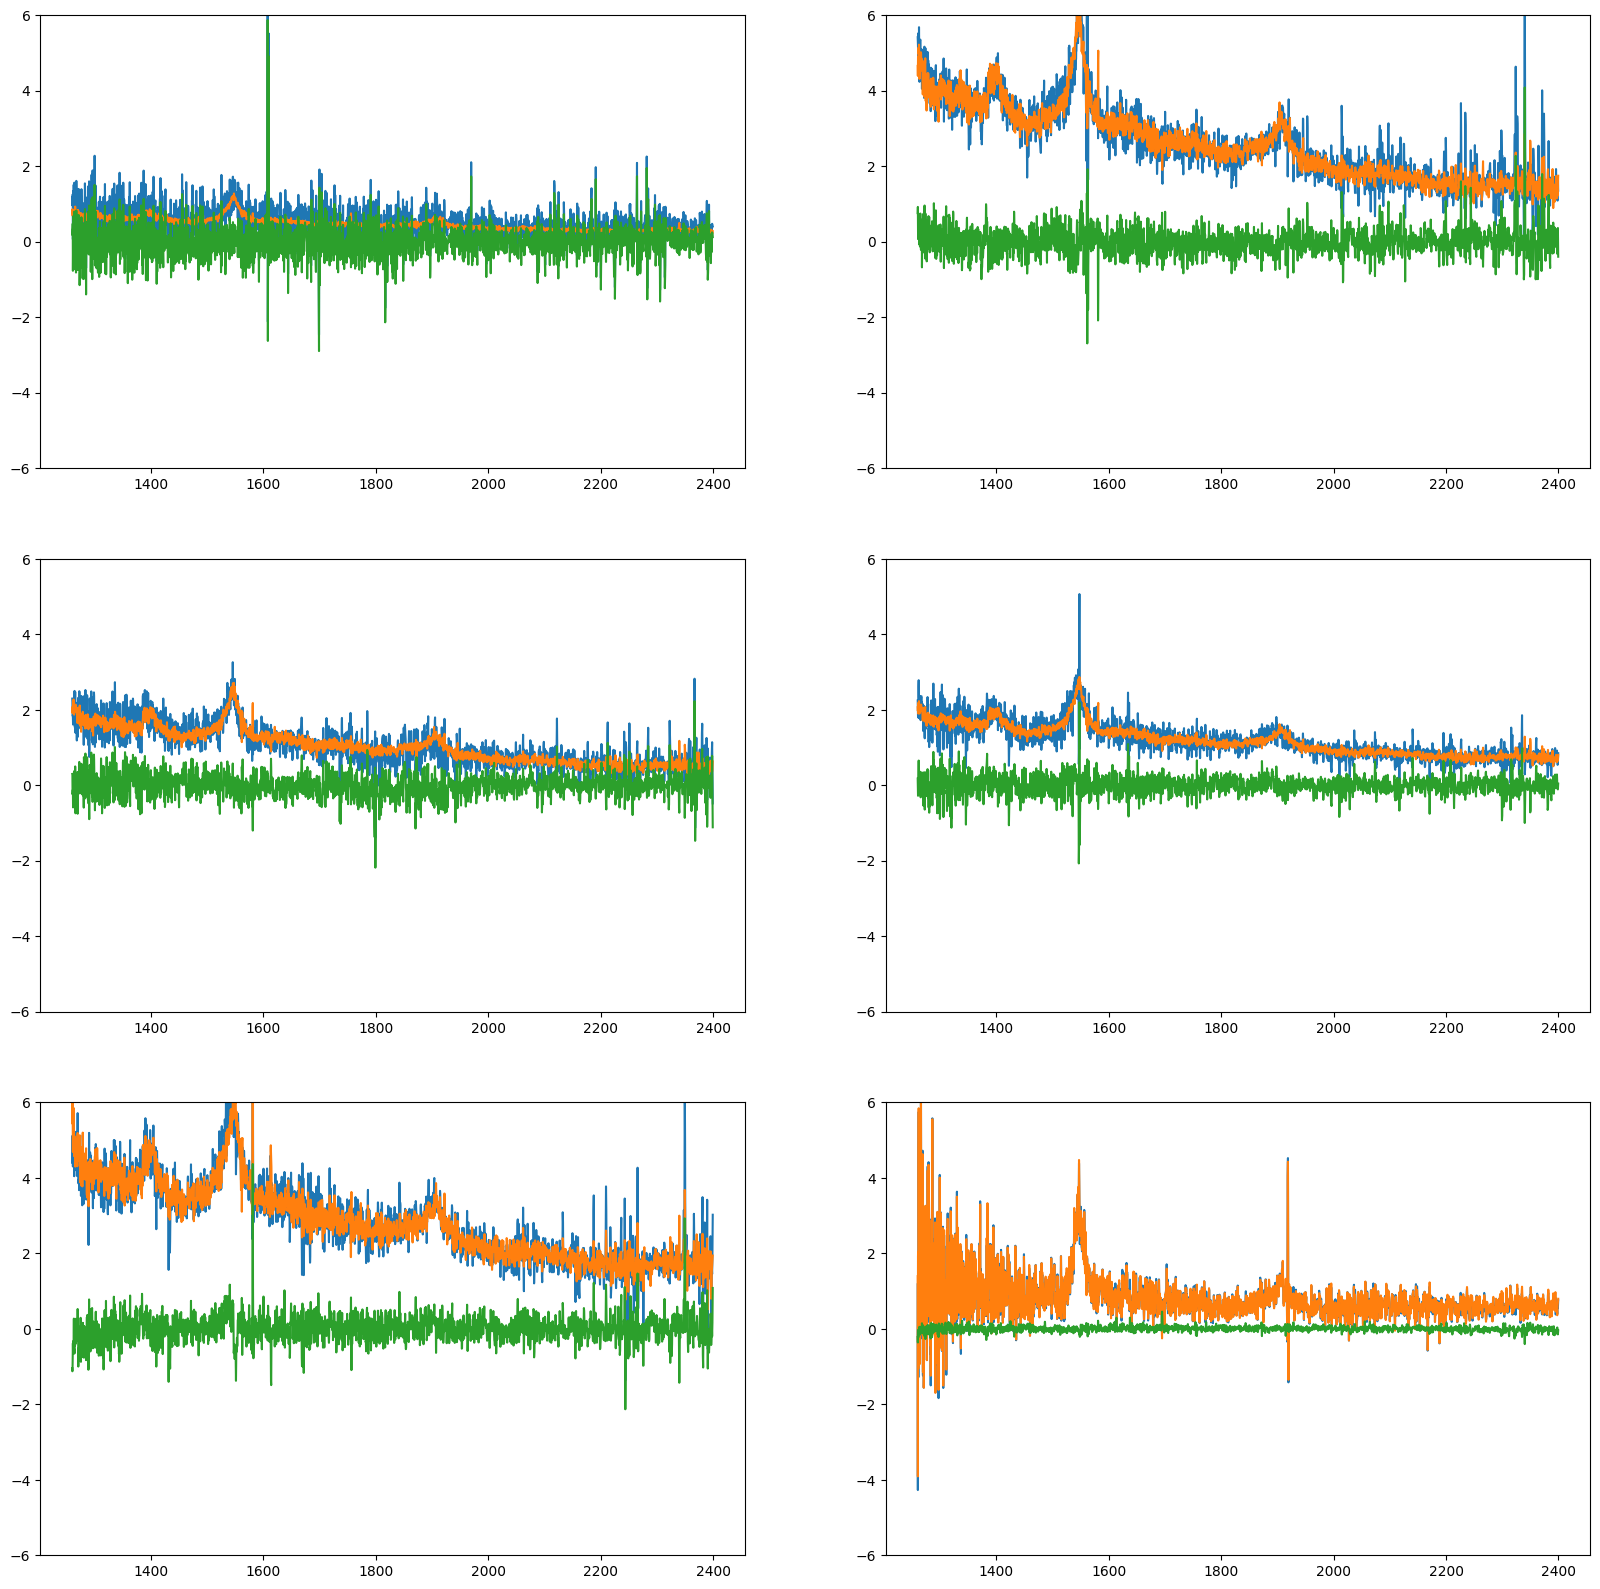

In [41]:
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
for i in np.arange(0,6):
    ax_i = axs[int(np.floor(i/2)), int(np.mod(i, 2))]
    ax_i.set_ylim(-6,6)
    ax_i.plot(wavelengths, X_train.T[i])
    ax_i.plot(wavelengths, X_original.T[i])
    ax_i.plot(wavelengths, X_diff.T[i])
    # ax_i.plot(wavelengths, .T[i])


In [44]:
spec = spec_l[0]

In [48]:
spec.radial_velocity

<Quantity 0. km / s>

In [49]:
from astroquery.sdss import SDSS

In [55]:
hdul = fits.open('../data/astroML_data/SDSSspec/10229/spec-10229-58441-0184.fits')

In [57]:
hdul.info()

Filename: ../data/astroML_data/SDSSspec/10229/spec-10229-58441-0184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     134   ()      
  1                1 BinTableHDU     33   4588R x 8C   [E, E, E, J, J, E, E, E]   
  2                1 BinTableHDU    501   1R x 236C   [5A, 7A, 4A, E, E, J, J, E, J, E, E, E, K, K, K, K, K, K, K, K, K, B, B, J, I, 5E, 5E, J, J, J, J, 7A, 7A, 3A, D, D, 3A, 9A, E, E, E, J, E, 21A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, 5E, E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, A, A, A, E, E, E, E, E, E, E, E, J, E, E, J, J, 4A, 13A, E, 35E, 19A, 19A, 19A, B, B, B, I, 3A, B, I, I, I, I, J, E, J, J, E, E, E, E, E, E, E, E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5J, 5J, 5J, 5E, 5J, 75E, 75E, 5E, 5E, 5E, 5J, 5E, D, D, D, D, D, D, D, D, D, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5

In [68]:
hdul[2].data['VDISP']

array([0.], dtype='>f4')

array(0.)

In [71]:
dr16q_filename = '../data/DR16Q_v4.fits'

hdul = fits.open(dr16q_filename)

In [72]:
hdr = hdul[0].header
dr16_data = hdul[1].data

In [74]:
bal_qso_mask = (dr16_data['BAL_PROB'] >= 0.95) & (dr16_data['zWarning'] == 0)
bal_qso_hdul = dr16_data[bal_qso_mask]

In [75]:
col_l = ['SDSS_NAME', 'RA', 'DEC', 'PLATE', 'MJD', 'FIBERID', 'AUTOCLASS_PQN', 'Z', 'BAL_PROB', 'BI_CIV', 'AI_CIV', ]
bal_qso_df = Table(bal_qso_hdul)[col_l].to_pandas()

In [77]:
bal_qso_df.iloc[[0]]

,SDSS_NAME,RA,DEC,PLATE,MJD,FIBERID,AUTOCLASS_PQN,Z,BAL_PROB,BI_CIV,AI_CIV
0,000001.41+200044.1,0.005912,20.012258,6110,56279,86,QSO,3.09,1.0,2680.030273,4101.962402


In [ ]:
from specutils import SpectrumCollection
from specutils.manipulation import FluxConservingResampler
fluxcon = FluxConservingResampler()

spec_l = []

for idx, row in bal_qso_df.iloc[0:10].iterrows():
    spec = fetch_sdss_spectrum(row.PLATE, row.MJD, row.FIBERID, row.Z, row.AUTOCLASS_PQN)
    spec.shift_spectrum_to(redshift=0)
    spec = spec[1260*u.AA:2400*u.AA]
    print(f'Processing spectrum {idx}')
    if idx == 0:
        spectral_axis = spec.spectral_axis
        bins = len(spec.spectral_axis)
    else:
        if not np.array_equal(spec.spectral_axis, spectral_axis):
            print('Resampling axis')
            spec = fluxcon(spec, spectral_axis)
    # Dropping masking stuff for now... Need to revisit
    spec.mask = np.full((len(spec.spectral_axis)), False)
    spec_l.append(spec)

In [362]:
from scipy.signal import find_peaks, peak_widths


def get_bal_mask(spec, rest_wavelength=1549.48, v_range=[-25000, 0], min_trough_depth=0.4, min_trough_width=2000, max_trough_width=25000, plt_return=False):
    # Finding the minimum limit to search for troughs i.e. blueshifts of up to -25,000km/s
    min_trough_lim = ( ( v_range[0]*u.km/u.s )/(astropy.constants.c) + 1 ) * ( rest_wavelength * u.AA )
    min_trough_disp = rest_wavelength * u.AA - min_trough_lim

    # Finding the minimum limit to search for troughs i.e. blueshifts of up to -25,000km/s
    min_bal_lim = ( ( min_trough_width*u.km/u.s )/(astropy.constants.c) + 1 ) * ( rest_wavelength * u.AA )
    min_bal_trough_width = np.abs(rest_wavelength * u.AA - min_bal_lim).value
    # Finding the max limit to search for troughs i.e. blueshifts of up to -25,000km/s
    max_bal_lim = ( ( max_trough_width*u.km/u.s )/(astropy.constants.c) + 1 ) * ( rest_wavelength * u.AA )
    max_bal_trough_width = np.abs(rest_wavelength * u.AA - max_bal_lim).value

    # Load quasar spectral data
    wavelength = np.array(spec.spectral_axis)
    flux = np.array(spec.flux)

    # flux = flux / np.nanmax(flux)

    # Finding the minimum limit to search for troughs i.e. blueshifts of up to -25,000km/s
    min_trough_lim = ( ( v_range[0]*u.km/u.s )/(astropy.constants.c) + 1 ) * ( rest_wavelength * u.AA )
    min_trough_disp = (rest_wavelength * u.AA - min_trough_lim).value

    # Find indices corresponding to the region of interest
    civ_indices = np.where((wavelength >= (rest_wavelength - min_trough_disp)) &
                        (wavelength <= rest_wavelength))[0]

    # Extract wavelength and flux data within the defined window
    civ_wavelength = wavelength[civ_indices]
    civ_flux = flux[civ_indices]

    # Smooth the flux data to enhance peak detection
    smoothed_flux = np.convolve(civ_flux, np.ones(5)/5, mode='valid')

    # Find peaks (troughs) in the smoothed flux data
    trough_indices, _ = find_peaks(-smoothed_flux, prominence = 1.5, width=[min_bal_trough_width,max_bal_trough_width] )
    trough_widths, _, _, _ = peak_widths(-smoothed_flux, trough_indices, rel_height=1)

    if len(trough_indices) > 0:
        # Set the mask region
        min_mask_wavelength = civ_wavelength[trough_indices.min()] - trough_widths[trough_indices.argmin()]/2
        bal_wavelength_mask = [min_mask_wavelength, rest_wavelength]
        
    else:
        bal_wavelength_mask = None

    if plt_return:
        return bal_wavelength_mask, wavelength, flux, civ_wavelength, smoothed_flux, civ_wavelength, trough_indices, trough_widths
    else:
        return bal_wavelength_mask

In [371]:
bal_wavelength_mask, wavelength, flux, civ_wavelength, smoothed_flux, civ_wavelength, trough_indices, trough_widths = get_bal_mask(spec_l[0], plt_return=True)


In [375]:
bal_wavelength_mask 

[1334.0844126757117, 1549.48]

In [379]:
# difference_array = np.absolute(wavelength-bal_wavelength_mask)
bal_idx_mask = []


np.absolute(wavelength-bal_wavelength_mask[0]).argmin()

898

In [380]:
np.arran(0,1)

AttributeError: module 'numpy' has no attribute 'arran'

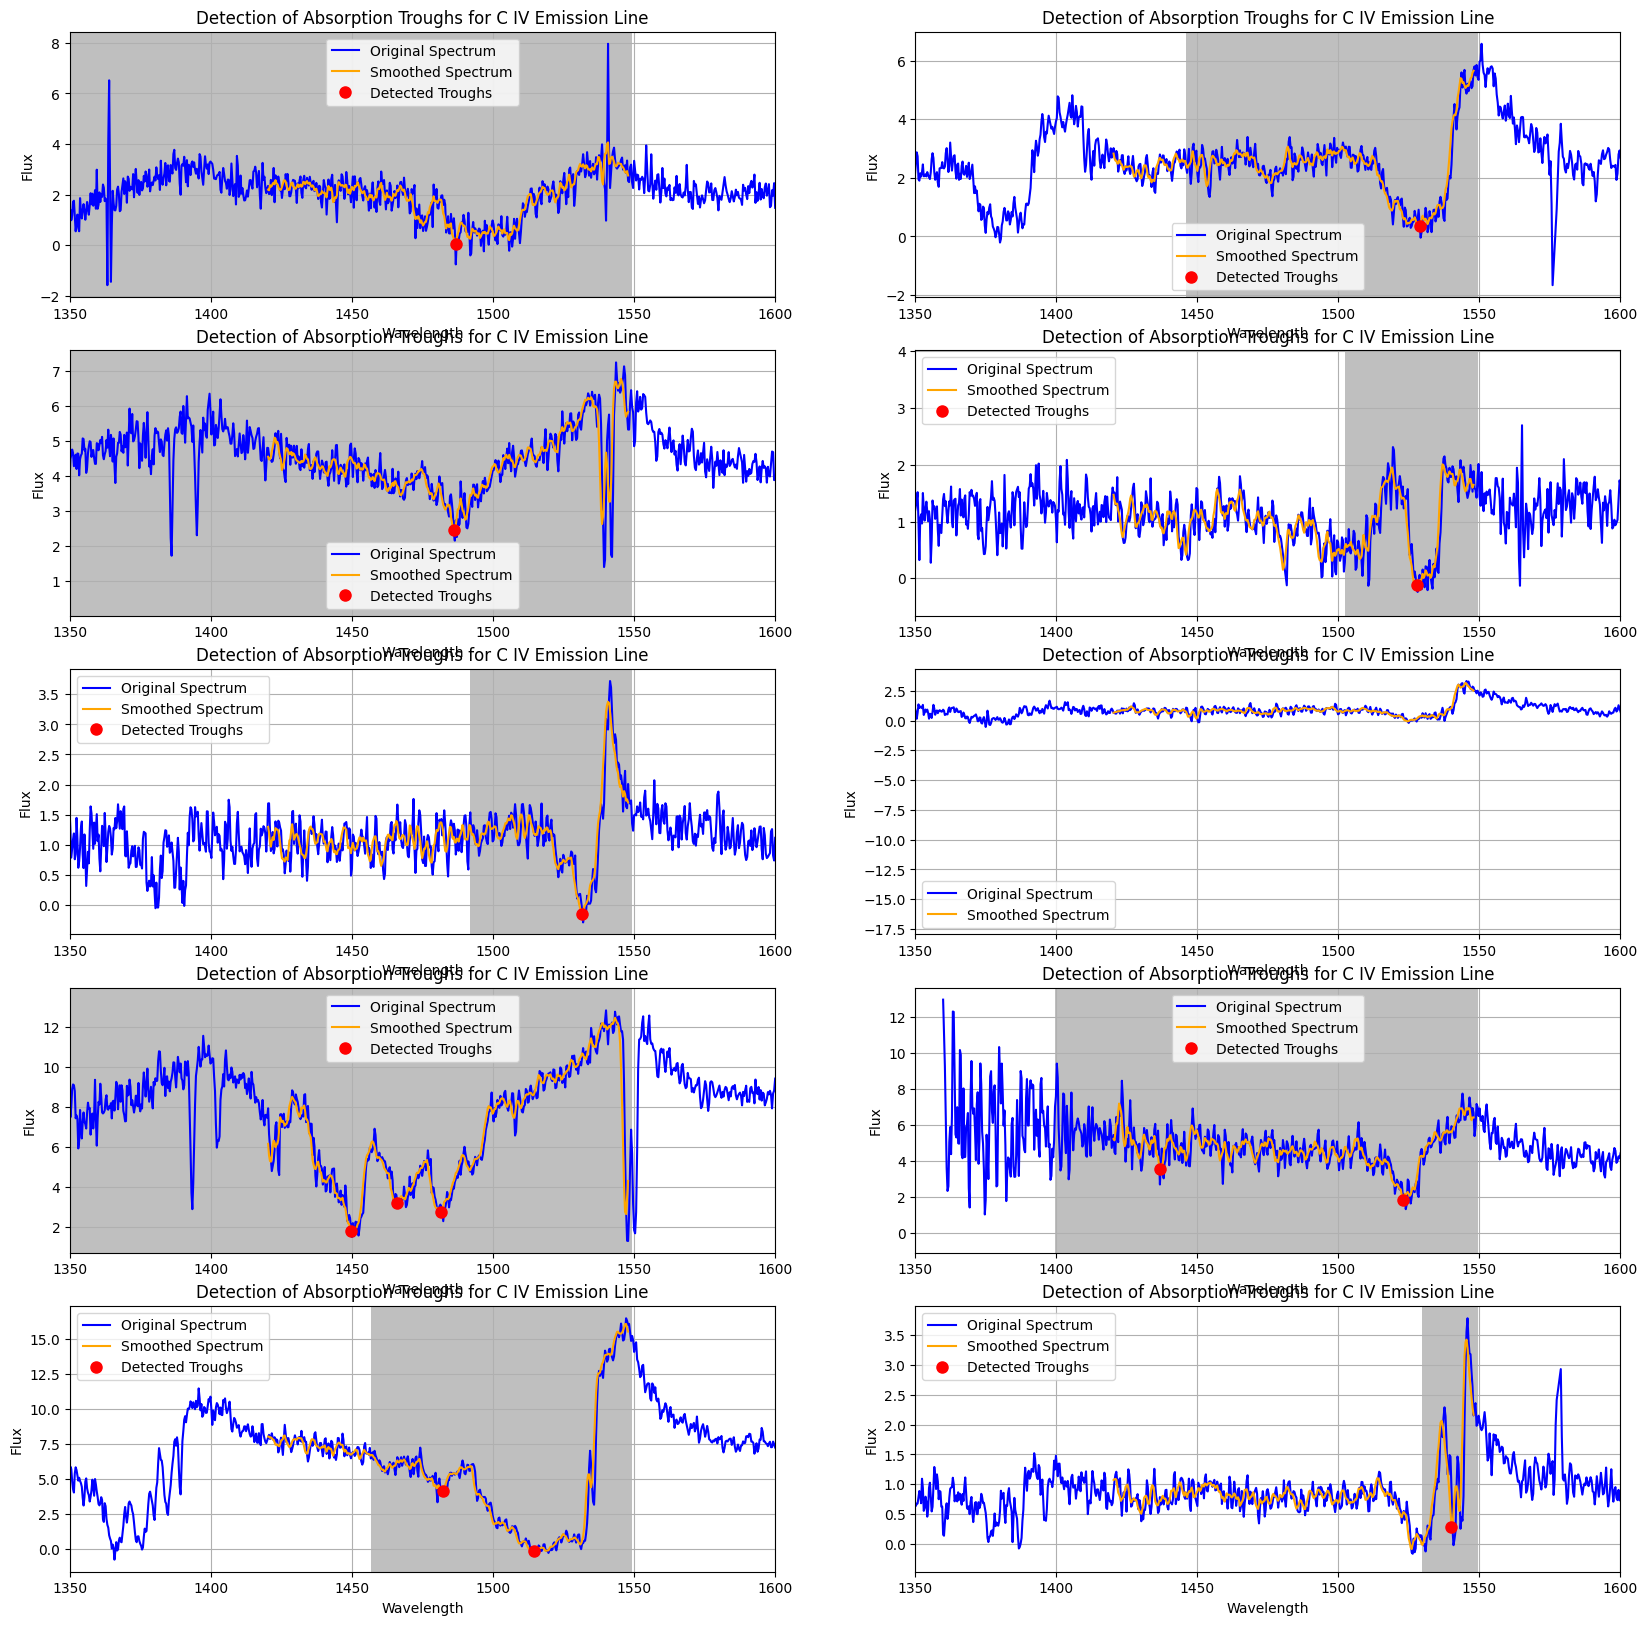

In [364]:

fig, axs = plt.subplots(5, 2, figsize=(20, 20))
   
for i in np.arange(0,len(spec_l)):
    bal_mask, wavelength, flux, civ_wavelength, smoothed_flux, civ_wavelength, trough_indices, trough_widths = get_bal_mask(spec_l[i], plt_return=True)
    ax_i = axs[int(np.floor(i/2)), int(np.mod(i, 2))]

    ax_i.plot(wavelength, flux, color='blue', label='Original Spectrum')
    ax_i.plot(civ_wavelength[:-4], smoothed_flux, color='orange', label='Smoothed Spectrum')
    if bal_mask:
        ax_i.plot(civ_wavelength[trough_indices], smoothed_flux[trough_indices], 'ro', markersize=8, label='Detected Troughs')
        ax_i.axvspan(bal_mask[0], bal_mask[1], facecolor='gray', alpha=.5)
    ax_i.set_xlabel('Wavelength')
    ax_i.set_xlim(1350, 1600)
    # ax_i.set_ylim(-1, 1)
    ax_i.set_ylabel('Flux')
    ax_i.set_title('Detection of Absorption Troughs for C IV Emission Line')
    ax_i.legend()
    ax_i.grid(True)
    

In [365]:
broad_trough_indices, broad_trough_widths = None, None

In [298]:
broad_trough_indices = [1,3,4]

if broad_trough_indices:
    print('yes')
else:
    print('no')

yes


In [286]:
bal_mask

[1515.8560060932462, 1549.48]

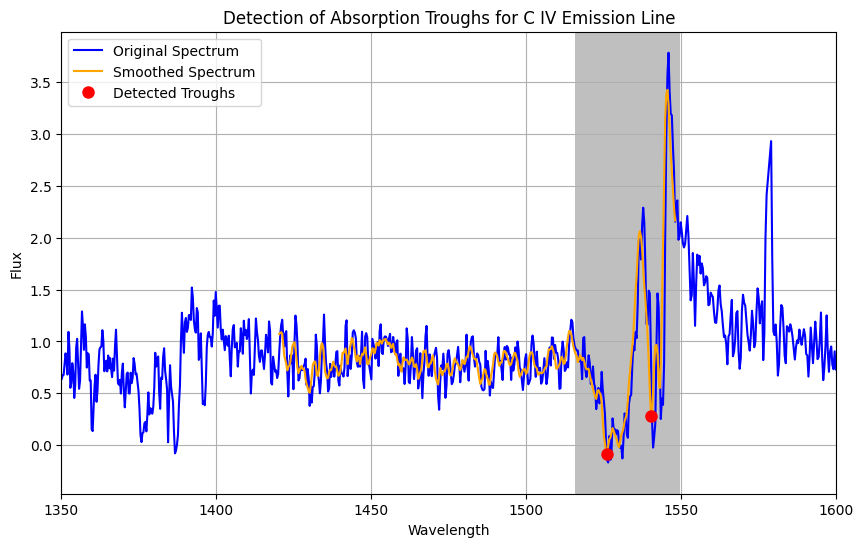

In [287]:
# Plot the original spectrum with detected absorption troughs
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(wavelength, flux, color='blue', label='Original Spectrum')
ax.plot(civ_wavelength[:-4], smoothed_flux, color='orange', label='Smoothed Spectrum')
ax.plot(civ_wavelength[broad_trough_indices], smoothed_flux[broad_trough_indices], 'ro', markersize=8, label='Detected Troughs')
ax.axvspan(bal_mask[0], bal_mask[1], facecolor='gray', alpha=.5)
ax.set_xlabel('Wavelength')
ax.set_xlim(1350, 1600)
ax.set_ylabel('Flux')
ax.set_title('Detection of Absorption Troughs for C IV Emission Line')
ax.legend()
ax.grid(True)
# ax.show()



In [225]:
bal_mask

[1515.8560060932462, 1549.48]

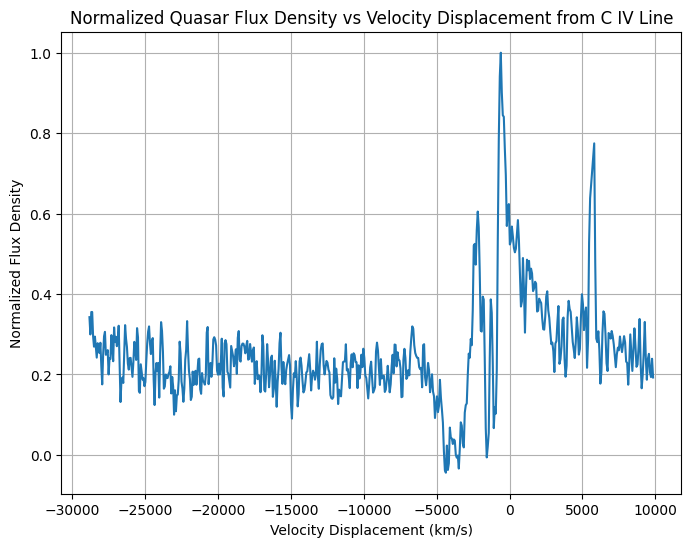

In [273]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace with your own)
wavelength = np.array(cut_spec.spectral_axis)  # Angstrom
flux = np.array(cut_spec.flux)   # Flux density in arbitrary units

# Rest wavelength of the C IV emission line
lambda_CIV = 1549  # Angstrom

# Speed of light in km/s
c_km_s = 3e5  # km/s

# Calculate velocity displacement from C IV line using Doppler formula (converted to km/s)
velocity_displacement_km_s = c_km_s * ((wavelength - lambda_CIV) / lambda_CIV)

# Normalize flux density (example normalization factor)
# You can choose different normalization methods based on your specific data and requirements
normalized_flux_density = flux_density / np.max(flux_density)

# Plotting the normalized flux density as a function of velocity displacement
plt.figure(figsize=(8, 6))
plt.plot(velocity_displacement_km_s, normalized_flux_density)
plt.xlabel('Velocity Displacement (km/s)')
plt.ylabel('Normalized Flux Density')
plt.title('Normalized Quasar Flux Density vs Velocity Displacement from C IV Line')
plt.grid(True)
plt.show()


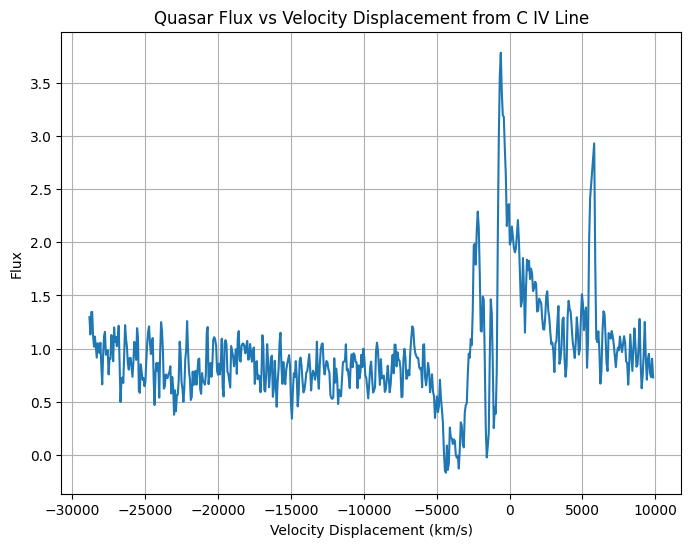

In [274]:
import numpy as np
import matplotlib.pyplot as plt



# Rest wavelength of the C IV emission line
lambda_CIV = 1549  # Angstrom

# Speed of light in km/s
c_km_s = 3e5  # km/s

# Calculate velocity displacement from C IV line using Doppler formula (converted to km/s)
velocity_displacement_km_s = c_km_s * ((wavelength - lambda_CIV) / lambda_CIV)

# Plotting the flux as a function of velocity displacement
plt.figure(figsize=(8, 6))
plt.plot(velocity_displacement_km_s, flux)
plt.xlabel('Velocity Displacement (km/s)')
plt.ylabel('Flux')
plt.title('Quasar Flux vs Velocity Displacement from C IV Line')
plt.grid(True)
plt.show()


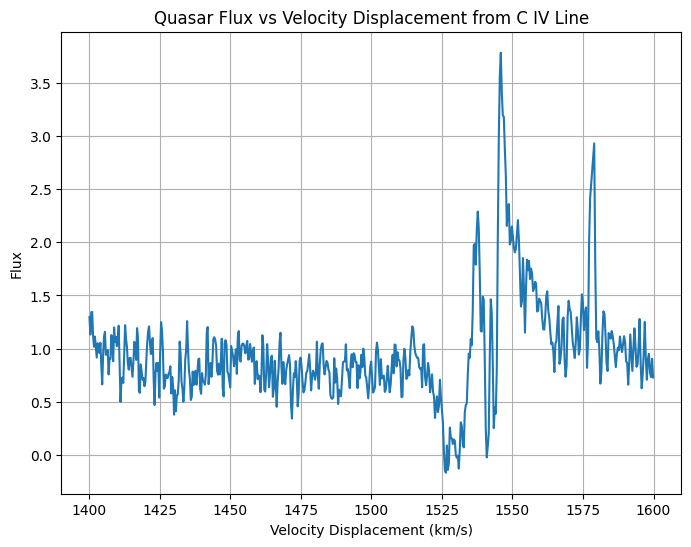

In [275]:
# Plotting the flux as a function of velocity displacement
plt.figure(figsize=(8, 6))
plt.plot(wavelength, flux)
plt.xlabel('Velocity Displacement (km/s)')
plt.ylabel('Flux')
plt.title('Quasar Flux vs Velocity Displacement from C IV Line')
plt.grid(True)
plt.show()

In [367]:
X_df = pd.read_csv('../data/pca/X_full.csv', index_col=0)

In [370]:
X_df.isnull().sum() * 100 / len(X_df)

0       60.699557
1       22.422484
2       22.330839
3       22.285016
4       22.269742
          ...    
2793     3.436689
2794     3.436689
2795     3.451963
2796     3.467237
2797    13.655109
Length: 2798, dtype: float64